In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Predict income

In [2]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.data', header=None, names = col_names)

In [6]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
# Distribution of income
df.income.value_counts(normalize=True)

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [3]:
# Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()

In [4]:
df['native-country'].value_counts(normalize=True)

native-country
United-States                 0.895857
Mexico                        0.019748
?                             0.017905
Philippines                   0.006081
Germany                       0.004207
Canada                        0.003716
Puerto-Rico                   0.003501
El-Salvador                   0.003255
India                         0.003071
Cuba                          0.002918
England                       0.002764
Jamaica                       0.002488
South                         0.002457
China                         0.002303
Italy                         0.002242
Dominican-Republic            0.002150
Vietnam                       0.002058
Guatemala                     0.001966
Japan                         0.001904
Poland                        0.001843
Columbia                      0.001812
Taiwan                        0.001566
Haiti                         0.001351
Iran                          0.001321
Portugal                      0.001136
Nicaragua 

In [5]:
# Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

In [6]:
X = pd.get_dummies(df[feature_cols], drop_first=True)

In [7]:
# Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = np.where(df.income == '<=50K', 0, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=.2)

In [9]:
# Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8189774297558728

In [10]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
accuracy_train=[]
accuracy_test = []

In [11]:
depths = range(1, 26)

In [12]:
for d in depths:
  rf = RandomForestClassifier(max_depth=d)
  rf.fit(X_train, y_train)
  accuracy_train.append(accuracy_score(y_train, rf.predict(X_train)))
  accuracy_test.append(accuracy_score(y_test, rf.predict(X_test)))

In [13]:
#Find the best accuracy and at what depth that occurs
print(np.max(accuracy_test))
best_depth = depths[np.argmax(accuracy_test)]
best_depth

0.8346384154767388


13

Text(0, 0.5, 'accuracy')

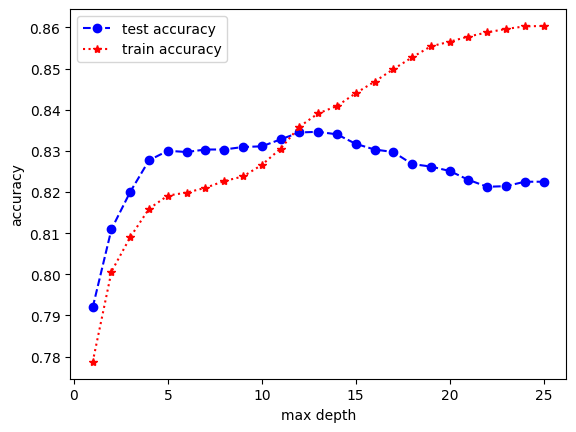

In [14]:
#Plot the accuracy scores for the test and train set over the range of depth values  
plt.plot(depths, accuracy_test, 'bo--',
         depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')

In [15]:
#Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",13
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [16]:
feat_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_), 
                           columns=['feature', 'importance'])

feat_imp_df.sort_values('importance', ascending=False).iloc[0:5]

,feature,importance
1,capital-gain,0.357894
0,age,0.251130
3,hours-per-week,0.148637
2,capital-loss,0.138748
4,sex_Male,0.081025


In [17]:
# Create two new features, based on education and native country
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], 
        labels=['HS or less', 'College to Bachelors', 'Masters or more'])

In [18]:
feature_cols.append('education_bin')
feature_cols.append('native-country')
feature_cols

['age',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'sex',
 'race',
 'education_bin',
 'native-country']

In [19]:
X = pd.get_dummies(df[feature_cols], drop_first=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=.2)

In [21]:
np.random.seed(0)
accuracy_train=[]
accuracy_test = []

In [22]:
for d in depths:
  rf = RandomForestClassifier(max_depth=d)
  rf.fit(X_train, y_train)
  accuracy_train.append(accuracy_score(y_train, rf.predict(X_train)))
  accuracy_test.append(accuracy_score(y_test, rf.predict(X_test)))

In [23]:
#Find the best max depth now with the additional two features
print(np.max(accuracy_test))
best_depth = depths[np.argmax(accuracy_test)]
best_depth

0.8492246276677414


18

Text(0, 0.5, 'accuracy')

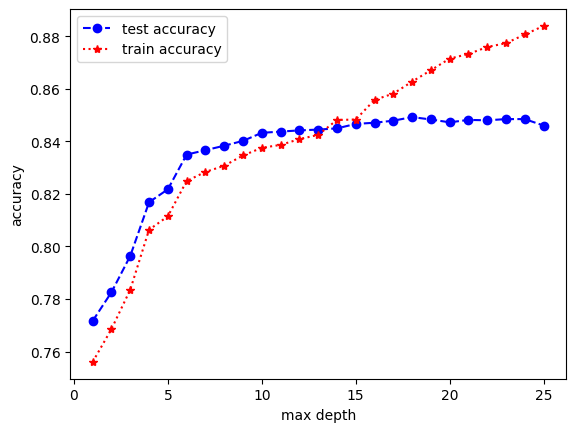

In [24]:
plt.plot(depths, accuracy_test, 'bo--',
         depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')

In [25]:
# Save the best model and print the two features with the new feature set
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

feat_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_), 
                           columns=['feature', 'importance'])
feat_imp_df.sort_values('importance', ascending=False).iloc[0:5]

,feature,importance
1,capital-gain,0.259343
0,age,0.234158
3,hours-per-week,0.126079
10,education_bin_Masters or more,0.114425
2,capital-loss,0.095111
